# Multiclass Instance Segmentations

The [detectron2-based](https://github.com/ivem-argonne/real-time-defect-analysis/blob/main/rtdefects/segmentation/detectron2.py#L14) models in our toolkit separate defects by type. 
Here, we show how to use them and interpret the results.

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.patches import Patch
from rtdefects.segmentation.detectron2 import Detectron2Segmenter
from rtdefects.io import load_file, read_then_encode
from imageio import v3 as iio
import numpy as np

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
example_image = '../files/300kV_60kX_AM316-ANL_0312-bf-thick1.jpg'

## Load the Example Image
Our example image contains both dislocation loops

TODO: Get an example from the AM dataset, which was used for training

In [3]:
image = load_file(example_image)

In [4]:
image = np.array(image * 255, dtype=np.uint8)

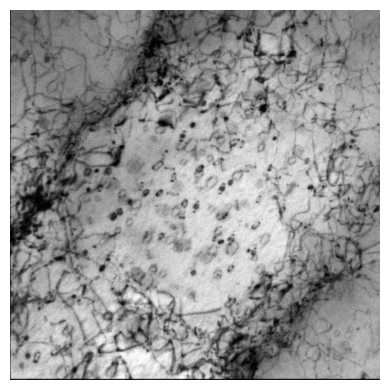

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.axis('off')

ax.imshow(image, cmap='gray')

fig.tight_layout()

## Run the Segmentation
The segmentation interface in `rtdefects` produces a stack of images where each image shows the location of a different defect.

In [6]:
segmenter = Detectron2Segmenter('detectron2-dislocations-23Feb24')

The first step is to transform the image into the shape expected by detectron2

In [7]:
image.shape

(1024, 1024)

In [8]:
reshaped_image = segmenter.transform_standard_image(image)
reshaped_image.shape

(1024, 1024, 3)

Then invoke the model

In [9]:
%%time
defect_mask = segmenter.perform_segmentation(reshaped_image)
print(f'The mask is shape {defect_mask.shape}. That means we detected {defect_mask.shape[0]} defects.')

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The mask is shape (121, 1024, 1024). That means we detected 121 defects.
CPU times: user 3.49 s, sys: 1.23 s, total: 4.72 s
Wall time: 2.71 s


## Visualizing Voids
Each frame showing the defect is a array where pixels are labeled by what type of defect they are.

In [10]:
defect_mask.shape

(121, 1024, 1024)

In [11]:
single_defect = defect_mask[0, :, :]

In [12]:
xis, yis = np.where(single_defect > 0)
xmin = xis[0]
ymin = yis[0]

In [13]:
single_defect[xmin:xmin+5, ymin:ymin+5]

array([[2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2]], dtype=int16)

See how this segment of the array has a positive integer for some pixels, those are the defect, and 0's for others, those are not.

The identity of the defect indicates the type it belongs to, which varies based on the model.

In [14]:
segmenter.class_names

['Edge-on-loops', 'Inclined-loops', 'Black-spot']

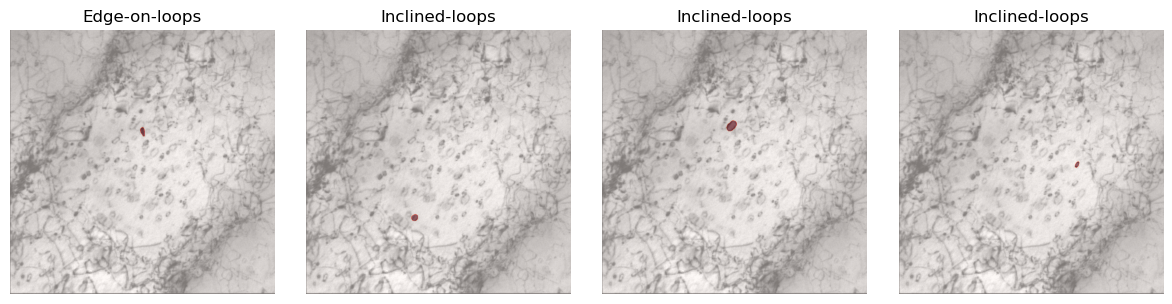

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i, ax in enumerate(axs):
    ax.axis('off')

    dtype = defect_mask[38 + i, :, :].max() - 1
    ax.set_title(segmenter.class_names[dtype])
    ax.imshow(image, cmap='gray')
    ax.imshow(defect_mask[38+i], alpha=0.5, cmap='Reds')

fig.tight_layout()

See how each region corresponds to a single defect within the image

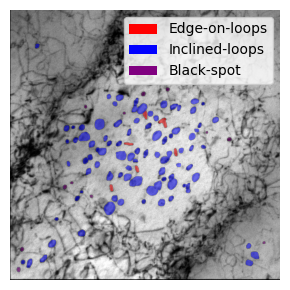

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.axis('off')

ax.imshow(image, cmap='gray')
colors = ['red', 'blue', 'purple']
overlay = np.zeros((*image.shape[:2], 4))
for mask in defect_mask:
    dtype = mask.max() - 1 
    rgb = mcolors.to_rgba(colors[dtype], alpha=0.5)
    overlay[mask > 0, :] = rgb
ax.imshow(overlay)

# Make the legend
handles = [Patch(facecolor=c, edgecolor='none') for c in colors]
ax.legend(handles, segmenter.class_names)

fig.tight_layout()
fig.savefig('example.png', dpi=320)